In [ ]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install moviepy

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import moviepy
from moviepy.editor import VideoFileClip

## Step 1: Camera Calibration

In [3]:
# Step 1- Camera calibration
#Creating an array for object Points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


objpoints=[] #3D points in real space 
imgpoints=[] #2D points in img space

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for index,image in enumerate(images):
    originalImage= cv2.imread(image)
    grayImg= cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY) #converting to Grayscale before finding Chessboard Corners

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(grayImg, (9,6), None)

    if(ret==True):
        objpoints.append(objp)
        imgpoints.append(corners)


## Step 2: Calculate Undistortion Parameters

In [4]:
# Step 2- Calculating Undistortion Parameters

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)


## Step 3: Undistort Images

In [5]:
# Step 3- Defining a function to undistort Images using parameters derived from previous step

def undistortImage(image):
    return cv2.undistort(image, mtx, dist, None, mtx)


images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder


## Step 4&5: ROI and Warping

In [6]:
# Step 4, 5- Defining a Region of Interest, Warping an Image from bird's eye view

left=[150,720] #left bottom most point of trapezium
right=[1250,720] #right bottom most point of trapezium
apex_left=[590,450] # left top most point of trapezium
apex_right=[700,450] # right top most point of trapezium

src=np.float32([left,apex_left,apex_right,right]) # Source Points for Image Warp
dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]]) # Destination Points for Image Warp


def ROI(originalImage):
    return cv2.polylines(originalImage,np.int32(np.array([[left,apex_left,apex_right,right]])),True,(0,0,255),10)

def WarpPerspective(image):
    y=image.shape[0]
    x=image.shape[1]
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(image, M, (x,y), flags=cv2.INTER_LINEAR)


## Step 6- Color Space

In [7]:
# Step 6- Selecting a Color Space

def ExtractChannel(image,colorspace,threshold,channel=0):
    colorspace = cv2.cvtColor(image, colorspace)
    extracted_channel = colorspace[:,:,channel]
    binary = np.zeros_like(extracted_channel)
    binary[(extracted_channel >= threshold[0]) & (extracted_channel <= threshold[1])] = 1
    return binary

## Sobel

In [8]:
# Step 7- Applying Sobel to warped image

def Sobel(warpedimage, threshold, sobelType, kernelSize=3):
    
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY) # Step 1- Convert to GrayScale
    sobelx = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernelSize)
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad= np.sqrt(sobelx**2 + sobely**2)
    
    arctan= np.arctan2(abs_sobely,abs_sobelx)
    
    valParam=abs_sobelx
    
    if(sobelType=='x'):
        valParam=abs_sobelx
    elif(sobelType=='y'):
        valParam= abs_sobely
    elif(sobelType=='xy'):
        valParam= grad
    else:
        valParam=arctan
        
    
    img = np.uint8((valParam* 255)/np.max(valParam)) # Creating a normalized sobel image
    binary_output = np.zeros_like(img)
    binary_output[(img > threshold[0]) & (img < threshold[1])]=1
    return binary_output

## Step 8: Combination

In [9]:
# Step 8- Combining Different ColorSpaces and Sobel Variants

def combineEverything(warpedImage, color_threshold, sobel_threshold):
    
    s_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,2)
    l_channel = ExtractChannel(warpedImage,cv2.COLOR_RGB2HLS,color_threshold,1)
    y_channel= ExtractChannel(warpedImage,cv2.COLOR_RGB2YUV,color_threshold,0)
    
    sobelx = Sobel(warpedImage, sobel_threshold, 'x')
    sobeldir= Sobel(warpedImage, [0.7,25], 'dir')
    #sobelxy=Sobel(warpedImage, sobel_threshold, 'xy')
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(((s_channel == 1) & (l_channel==1)) & (y_channel==1)) | (sobelx == 1)  ] = 1
    return combined_binary



## Step 9: Histogram

In [10]:
# Step 9 Plotting Histogram

def Histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)




## Step 10: Find Lanes

In [11]:
# Step 10- Sliding Window Search
def SlidingWindowSearch(binary_warped, plot=False):

    histogram = Histogram(binary_warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if(plot==True):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,out_img

In [12]:
# Draw Sliding Window Visualization

def VisualizeSlidingWindow(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    plt.figure(figsize=(20,10))
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    #return out_img

In [13]:
# Visualizing Smoothly

def VisualizeLaneDetection(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,out_img):
    margin = 100
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    
 
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    
    
    plt.figure(figsize=(20,10))
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


## Step 11: Unwarp

In [14]:
# Unwarp Image and plot line

def DrawLine(original_image,binary_warped, left_fit, right_fit):
    
    h,w= binary_warped.shape
    Minv = cv2.getPerspectiveTransform(dst, src)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
   
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    #axes[index+1].imshow(newwarp)
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result



## Step 12: Calculate Radius and Distance

In [15]:
def CalculateRadiusOfCurvature(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    positionCar= binary_warped.shape[1]/2
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    actualPosition= (left_lane_bottom+ right_lane_bottom)/2
    
    distance= (positionCar - actualPosition)* xm_per_pix
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return (left_curverad + right_curverad)/2, distance
    # Example values: 632.1 m    626.2 m



## Step 13- Defining Pipeline

In [16]:
from random import randint
import datetime
import time
DEGUG = False

    
def pipeline(originalImage):
    originalImage= cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
    undistortedImage= undistortImage(originalImage)
    warpedImage= WarpPerspective(undistortedImage)
    combinedImage= combineEverything(warpedImage,color_threshold= [100,255],sobel_threshold=[10,150])
    returnedOutput =  SlidingWindowSearch(combinedImage)
    left_fit=returnedOutput[0]
    right_fit=returnedOutput[1]
    #VisualizeSlidingWindow(combinedImage, left_fit,right_fit, returnedOutput[2], returnedOutput[3],returnedOutput[4])
    finalImage=DrawLine(originalImage,combinedImage,left_fit,right_fit)
    #cv2.imwrite('./test/'+str(randint(0, 99999))+'.jpg',originalImage)
    
    radius, distance = CalculateRadiusOfCurvature(combinedImage,left_fit,right_fit)
    cv2.putText(finalImage,"Radius of Curvature is " + str(int(radius))+ "m", (100,100), 2, 1, (255,255,0),2)
    #print(distance)
    cv2.putText(finalImage,"Distance from center is {:2f}".format(distance)+ "m", (100,150), 2, 1, (255,255,0),2)
    ts = time.time()
    st = datetime.datetime.fromtimestamp(ts).strftime('%Y%m%d %H%M%S')
        
    newCombinedImage= np.dstack((combinedImage*255,combinedImage*255,combinedImage*255))
    finalImage[100:240,1000:1200, :]= cv2.resize(newCombinedImage, (200,140))

        
    return cv2.cvtColor(undistortedImage, cv2.COLOR_BGR2RGB), cv2.cvtColor(warpedImage, cv2.COLOR_BGR2RGB), cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB)

## Step 14- Running Pipeline on Test Images

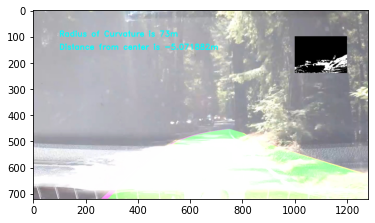

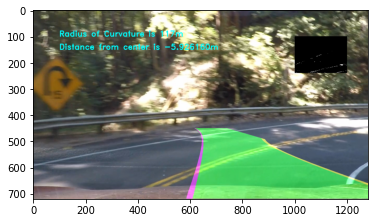

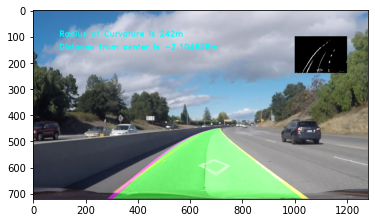

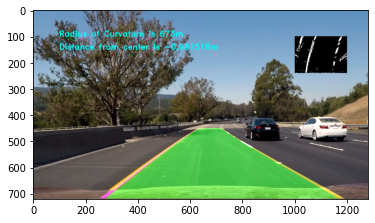

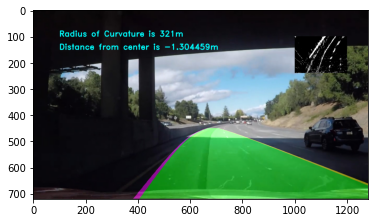

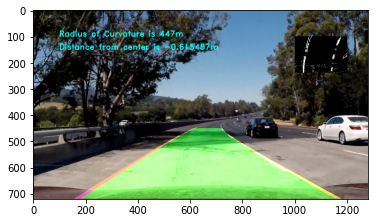

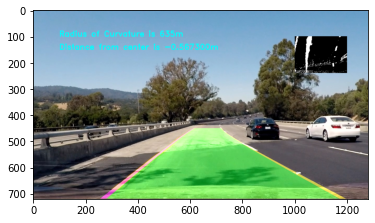

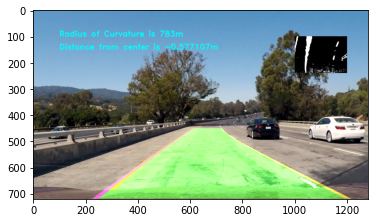

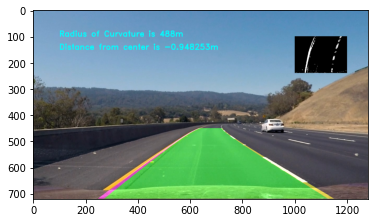

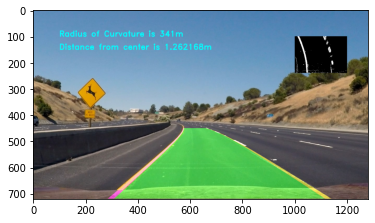

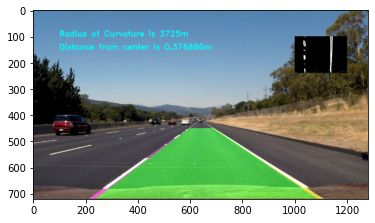

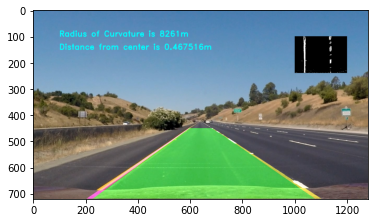

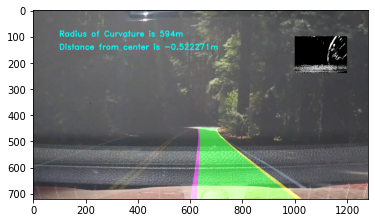

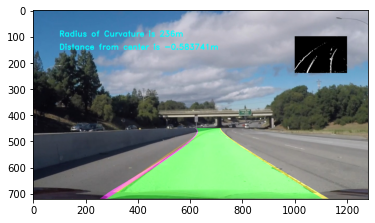

In [18]:
#testing on test images
DEBUG = False

images = glob.glob('test_images/*.jpg') # Reading Images from test_images folder

if DEBUG:

    f, axes= plt.subplots(14,4,figsize=(15,30))
    for index, image in enumerate(images):
        originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        undistortedImage, warpedImage, finalImage = pipeline(originalImage)
        axes[index,0].imshow(originalImage)
        axes[index,1].imshow(undistortedImage)
        axes[index,2].imshow(warpedImage)
        axes[index,3].imshow(finalImage)
        
else:
    for index, image in enumerate(images):
        originalImage= cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
        _, _, finalImage = pipeline(originalImage)
        plt.figure()
        plt.imshow(finalImage)



## Step 15- Running Pipeline on Video

In [24]:
import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: user 3min 2s, sys: 1min 2s, total: 4min 4s
Wall time: 3min 35s


In [23]:
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 1min 8s, sys: 22.7 s, total: 1min 30s
Wall time: 1min 17s
